<a href="https://colab.research.google.com/github/Aadityasindhuu/Aadityasindhuu/blob/main/Forest_Cover_Type_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn --quiet

In [2]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [4]:
# For file upload in Colab
from google.colab import files

# Step 3: Upload the dataset
uploaded = files.upload()

# Get the uploaded CSV file name
csv_filename = next(iter(uploaded))
print(f"Uploaded file: {csv_filename}")

Saving train.csv to train.csv
Uploaded file: train.csv


In [5]:
# Step 4: Load the dataset
df = pd.read_csv(csv_filename)

In [6]:
# Step 5: Exploratory Data Analysis
print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nFirst 5 rows:\n{df.head()}")
print(f"\nMissing values:\n{df.isnull().sum()}")


Dataset Info:
Shape: (15120, 56)

First 5 rows:
   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            14

In [7]:
# Check for any ID-like columns that shouldn't be used as features
if 'Id' in df.columns:
    print("\nDropping 'Id' column as it's not a meaningful feature")
    df.drop('Id', axis=1, inplace=True)


Dropping 'Id' column as it's not a meaningful feature


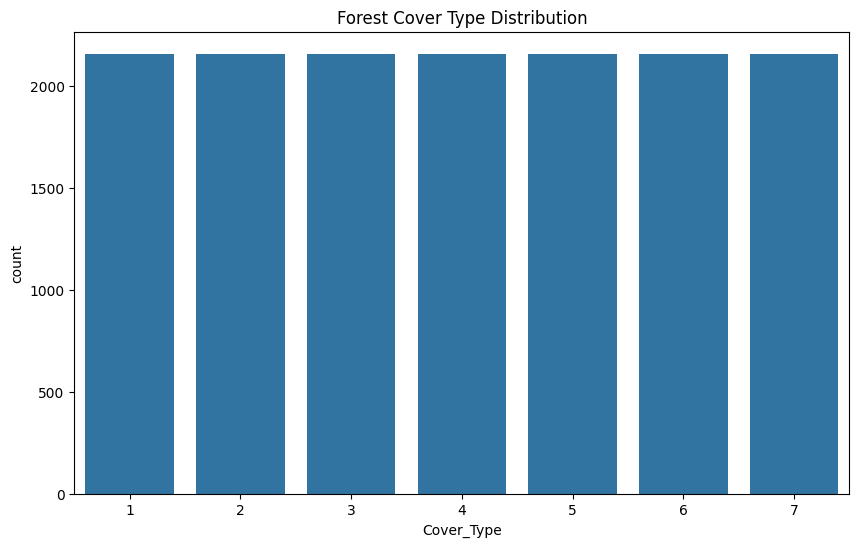

In [8]:
# Class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cover_Type', data=df)
plt.title('Forest Cover Type Distribution')
plt.show()

In [9]:
# Step 6: Data Preprocessing
# Split into features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numerical features
numerical_cols = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
    'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]

# Verify all numerical columns exist in the dataset
numerical_cols = [col for col in numerical_cols if col in X_train.columns]
print(f"\nNumerical columns being scaled: {numerical_cols}")


Numerical columns being scaled: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


In [10]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Handle class imbalance using SMOTE
print("\nOriginal class distribution:")
print(y_train.value_counts())


Original class distribution:
Cover_Type
5    1728
6    1728
1    1728
7    1728
3    1728
4    1728
2    1728
Name: count, dtype: int64


In [11]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())


Class distribution after SMOTE:
Cover_Type
5    1728
6    1728
1    1728
7    1728
3    1728
4    1728
2    1728
Name: count, dtype: int64


In [12]:
# Step 7: Model Training - Random Forest
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_res, y_train_res)

# Model evaluation
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Training Random Forest Classifier...

Random Forest Classifier Performance:
Accuracy: 0.8449

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.76      0.77       432
           2       0.78      0.66      0.71       432
           3       0.81      0.78      0.79       432
           4       0.93      0.97      0.95       432
           5       0.87      0.94      0.90       432
           6       0.80      0.85      0.82       432
           7       0.93      0.96      0.95       432

    accuracy                           0.84      3024
   macro avg       0.84      0.84      0.84      3024
weighted avg       0.84      0.84      0.84      3024



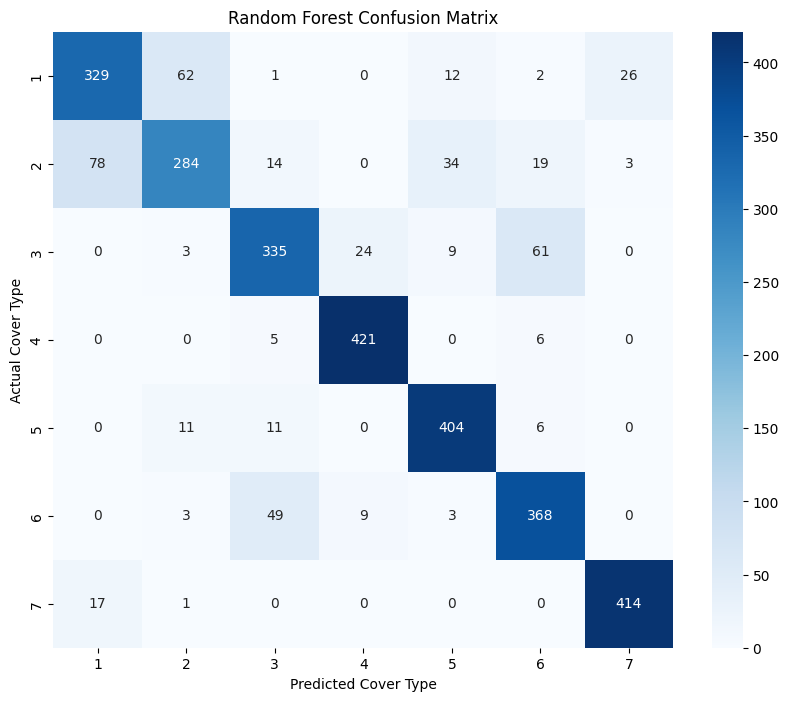

In [13]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Cover Type')
plt.ylabel('Actual Cover Type')
plt.show()

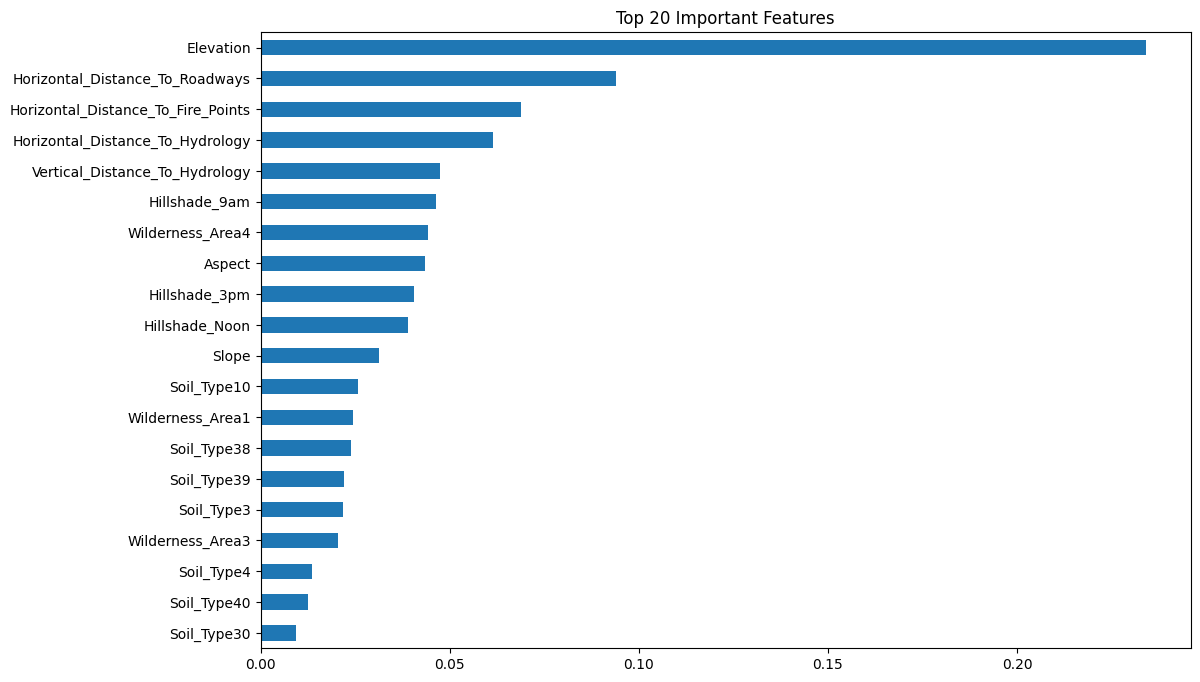

In [14]:
# Step 8: Feature Importance Analysis
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = feat_importances.nlargest(20)
top_features.sort_values().plot(kind='barh')
plt.title('Top 20 Important Features')
plt.show()

In [16]:
# Step 9: Model Training - XGBoost
print("\nTraining XGBoost Classifier...")

# Convert class labels to start from 0 (XGBoost requirement)
y_train_res_xgb = y_train_res - 1
y_test_xgb = y_test - 1

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1,
    objective='multi:softmax',
    num_class=7  # Explicitly specify number of classes
)

xgb_model.fit(X_train_res, y_train_res_xgb)

# Model evaluation
y_pred_xgb = xgb_model.predict(X_test)

# Convert predictions back to original label range (1-7)
y_pred_xgb = y_pred_xgb + 1

print("\nXGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


Training XGBoost Classifier...

XGBoost Classifier Performance:
Accuracy: 0.8664

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.76      0.77       432
           2       0.77      0.67      0.72       432
           3       0.86      0.84      0.85       432
           4       0.95      0.98      0.97       432
           5       0.89      0.95      0.92       432
           6       0.85      0.90      0.87       432
           7       0.93      0.97      0.95       432

    accuracy                           0.87      3024
   macro avg       0.86      0.87      0.86      3024
weighted avg       0.86      0.87      0.86      3024



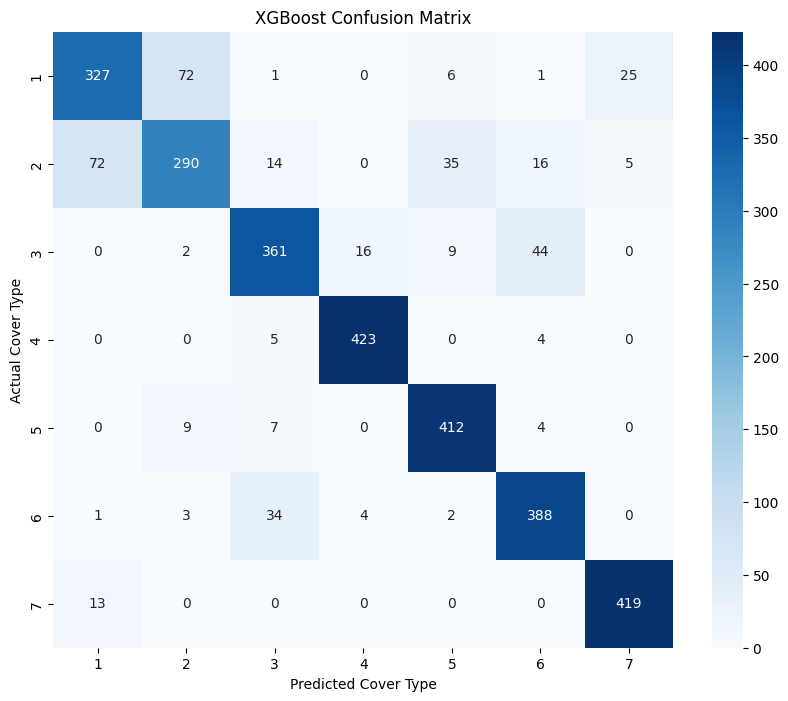

In [17]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Cover Type')
plt.ylabel('Actual Cover Type')
plt.show()

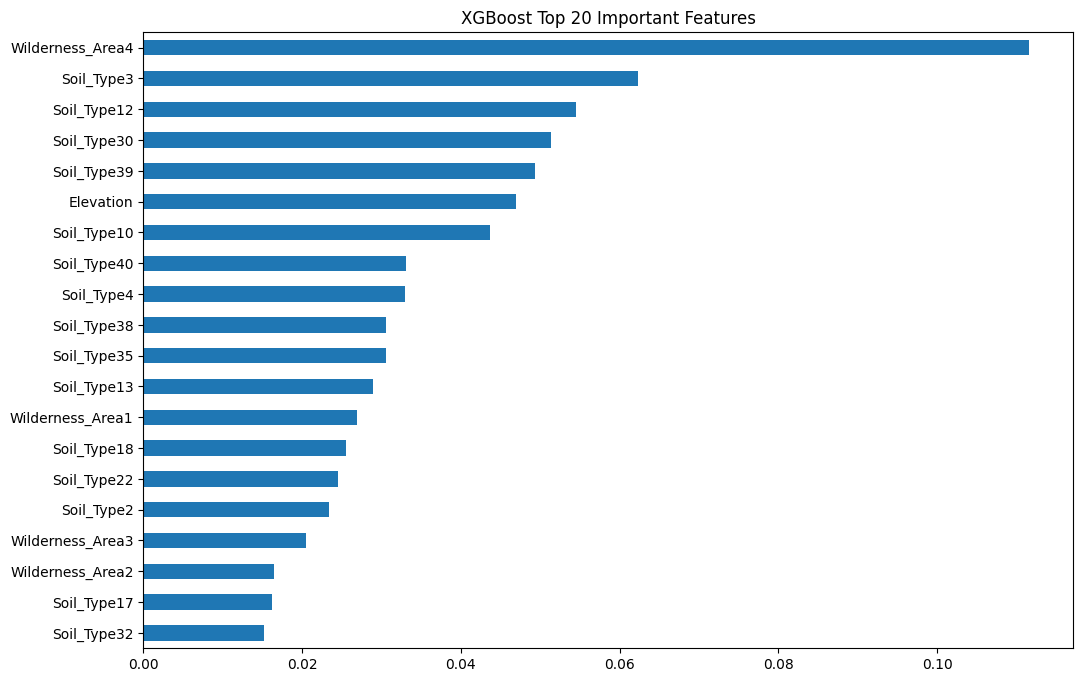

In [18]:
# XGBoost Feature Importance
plt.figure(figsize=(12, 8))
xgb_feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_top_features = xgb_feat_importances.nlargest(20)
xgb_top_features.sort_values().plot(kind='barh')
plt.title('XGBoost Top 20 Important Features')
plt.show()

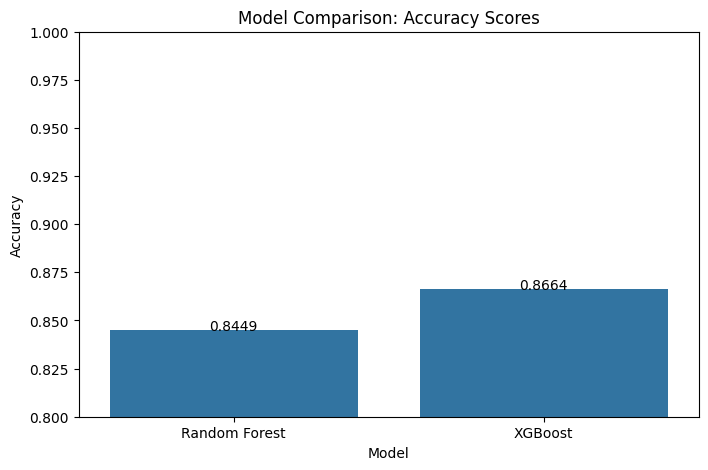

In [19]:
# Step 10: Compare Model Performances
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Model Comparison: Accuracy Scores')
plt.ylim(0.8, 1.0)
for index, row in results.iterrows():
    plt.text(index, row.Accuracy, f"{row.Accuracy:.4f}", ha='center')
plt.show()